# Anwendungsbeispiel Import of text data with sentiment classification

In diesem Beispiel werden wir Textdaten behandeln und versuchen die Stimmung eines kurzen Stückes Text zu bestimmen. Damit können zum Beispiel eMails oder Social Media Beiträge gefiltert werden.





- [2] [https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/](https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/)
- [3] https://gdcoder.com/sentiment-clas/
- [4] [https://nlp.stanford.edu/pubs/glove.pdf](https://nlp.stanford.edu/pubs/glove.pdf)


Zitierungen:
```
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

```









In [100]:
#
# Import der Module
#
import os
import re
import string
from urllib.request import urlretrieve
import tarfile
import zipfile
from glob import glob

import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# Konstanten

In [32]:
#
# Konstanten für Dateien
#
urlDataSource = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
localExtractionFolder = 'data/moviereviews'
localDataArchive = localExtractionFolder + '/aclImdb_v1.tar.gz'
textData = localExtractionFolder + '/aclImdb/'

# Hilfsfunktionen

In [106]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,dataset_file_path,extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if os.path.exists(dataset_file_path):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {} to {}".format(url,filename))

def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Laden und erster Check

In [107]:
#
# Laden der Daten ausführen
#
download_dataset(urlDataSource,localDataArchive,localExtractionFolder)

archive already downloaded.


In [20]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/moviereviews/aclImdb_v1.tar.gz to data/moviereviews done.


In [35]:
#
# Sammeln der Daten aus den Files
#
def load_texts_labels_from_folders(path, folders):
    print('scanning path {}'.format(path))
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        print('scanning {}'.format(idx))
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    return texts, np.array(labels).astype(np.int8)

In [80]:
classes = ['neg','pos']
x_train,y_train = load_texts_labels_from_folders( textData + 'train', classes)
x_test,y_test = load_texts_labels_from_folders( textData + 'test', classes)

scanning path data/moviereviews/aclImdb/train
scanning 0
scanning 1
scanning path data/moviereviews/aclImdb/test
scanning 0
scanning 1


In [81]:
len(x_train),len(y_train),len(x_test),len(y_test)

(25000, 25000, 25000, 25000)

In [82]:
#
# Prüfen des Datentypen
#
(type(x_train),type(y_train))

(list, numpy.ndarray)

In [83]:
#
# Prüfen der Klassen
#
np.unique(y_train)

array([0, 1], dtype=int8)

In [84]:
#
# negative Beispiele
#
for index in range (0,1):
    print(x_train[index])
    print("label {}".format(y_train[index]))
    print()

Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.
label 0



In [85]:
#
# positive Beispiele
#
for index in range (13001,13002):
    print(x_train[index])
    print("label {}".format(y_train[index]))
    print()


What we have here is a damn good little nineties thriller that, while perhaps lacking in substance, still provides great entertainment throughout it's running time and overall does everything you could possibly want a film of this nature to do. I saw this film principally because it was directed by John Dahl - a highly underrated director behind great thrillers such as The Last Seduction, Rounders and Roadkill. I figured that if this film was up to standard of what I've already seen from the director, it would be well worth watching - and Red Rock West is certainly a film that Dahl can be proud of. The plot focuses on the overly moral Michael; a man travelling across America looking for work. He ends up finding it one day when he stumbles upon a bar in Red Rock County - only catch is that the job is to murder a man's wife. He's been mistaken for a killer named Lyle, but instead of doing the job; he plays both sides against each other and eventually plans to make a getaway. However, his

# Zerlegen der Texte in Worte und Reinigung

In [86]:
#
# Reinigungsfunktion
#

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [87]:
x_train_clean = []
for review in x_train:
    x_train_clean.append(preprocess_text(review))
    
x_test_clean = []
for review in x_test:
    x_test_clean.append(preprocess_text(review))  
    
x_test = x_test_clean
x_train = x_train_clean

In [88]:
for index in range (0,1):
    print(x_train[index])
    print("label {}".format(y_train[index]))
    print()

Working with one of the best Shakespeare sources this film manages to be creditable to it source whilst still appealing to wider audience Branagh steals the film from under Fishburne nose and there a talented cast on good form 
label 0



length mean 1236.42548


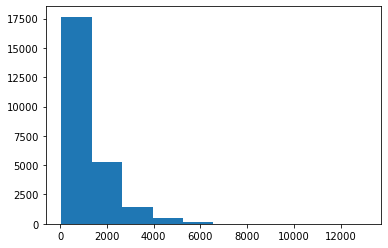

In [92]:
#
# Zählen der Längen der Texte
#
textLength = []
for index in range (0,len(x_train)):
    textLength.append(len(x_train[index]))

plt.hist(textLength)
lengthArray = np.array(textLength)
print('length mean {}'.format(np.mean(lengthArray)))

# Umwandeln der Worte in Vektoren

In [67]:
#
# Zerlegung der Sätze in Worte
#
tokenizer = Tokenizer(num_words=10000, lower=True, oov_token='unknwn')
tokenizer.fit_on_texts(x_train)

In [68]:
x_train_v = tokenizer.texts_to_sequences(x_train)
x_test_v = tokenizer.texts_to_sequences(x_test)

In [73]:
print(x_train_v[0])

[759, 14, 26, 4, 2, 113, 1761, 6690, 9, 17, 1000, 5, 25, 1, 5, 7, 2376, 1838, 127, 2236, 5, 6880, 297, 2597, 2330, 2, 17, 34, 456, 5838, 3135, 3, 36, 129, 995, 175, 19, 46, 788]


length mean 222.87924


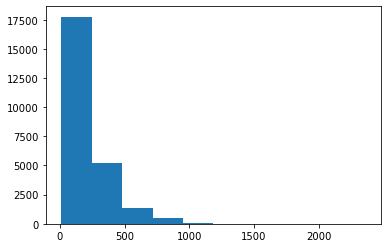

In [93]:
#
# Zählen der Längen der vektorisierten Texte
#
textLength = []
for index in range (0,len(x_train_v)):
    textLength.append(len(x_train_v[index]))

plt.hist(textLength)
lengthArray = np.array(textLength)
print('length mean {}'.format(np.mean(lengthArray)))

In [94]:
#
#
#
vocab_size = len(tokenizer.word_index) + 1
print('count of words {}'.format(vocab_size))

count of words 74220


In [95]:
maxlen = 200

x_train = pad_sequences(x_train_v, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test_v, padding='post', maxlen=maxlen)

# Umrechnung in einen dichten Vektorraum (glove)

In [113]:
gloveUrl = 'http://nlp.stanford.edu/data/glove.6B.zip'
gloveExtractionFolder = 'data/glove'
gloveDataArchive = gloveExtractionFolder + '/glove.6B.zip'
gloveData = gloveExtractionFolder + '/' + 'glove.6B.100d.txt'

gloveDims = 100

In [103]:
def unzip_dataset(dataset_file_path, extraction_directory):  
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)        
    zip = zipfile.ZipFile(dataset_file_path)
    zip.extractall(path=extraction_directory)        
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )

In [108]:
#
# Laden der Daten ausführen
#
download_dataset(gloveUrl,gloveDataArchive,gloveExtractionFolder)

started loading archive from url http://nlp.stanford.edu/data/glove.6B.zip
finished loading archive from url http://nlp.stanford.edu/data/glove.6B.zip to data/moviereviews/glove.6B.zip


In [110]:
unzip_dataset(gloveDataArchive,gloveExtractionFolder)

extraction of dataset from data/moviereviews/glove.6B.zip to data/glove done.


In [114]:
embeddings_dictionary = dict()
glove_file = open(gloveData, encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [115]:
embedding_matrix = np.zeros((vocab_size, gloveDims))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [116]:
print(embedding_matrix.shape)

(74220, 100)


In [117]:
def createModel():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, gloveDims, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [118]:
model = createModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          7422000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 20001     
Total params: 7,442,001
Trainable params: 20,001
Non-trainable params: 7,422,000
_________________________________________________________________
None


In [119]:
history = model.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/6
20000/20000 [==============================] - 2s 89us/step - loss: 0.5873 - acc: 0.6932 - val_loss: 1.2472 - val_acc: 0.2782
Epoch 2/6
20000/20000 [==============================] - 1s 46us/step - loss: 0.4295 - acc: 0.8066 - val_loss: 0.8683 - val_acc: 0.5212
Epoch 3/6
20000/20000 [==============================] - 1s 47us/step - loss: 0.3682 - acc: 0.8468 - val_loss: 0.7443 - val_acc: 0.6142
Epoch 4/6
20000/20000 [==============================] - 1s 49us/step - loss: 0.3194 - acc: 0.8715 - val_loss: 0.6225 - val_acc: 0.7046
Epoch 5/6
20000/20000 [==============================] - 1s 46us/step - loss: 0.2850 - acc: 0.8947 - val_loss: 0.7274 - val_acc: 0.6644
Epoch 6/6
20000/20000 [==============================] - 1s 48us/step - loss: 0.2599 - acc: 0.9050 - val_loss: 0.8296 - val_acc: 0.6158


In [120]:
score = model.evaluate(x_test, y_test, verbose=1)

25000/25000 [==============================] - 1s 47us/step


In [121]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6360132757377625
Test Accuracy: 0.712440013885498


In [124]:
def plotResults(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

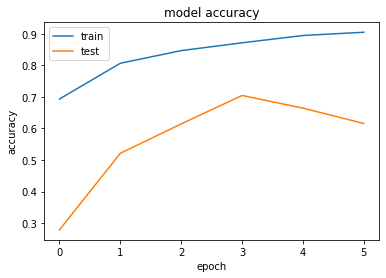

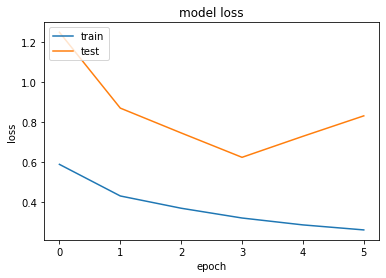

In [125]:
plotResults(history)

# Verbessertes Modell

# Test mit neuen Daten

In [128]:
instance = x_test_clean[57]
print(instance)

 Possible Spoilers Ahead Whenever fans of bad movies congregate for more than few minutes name that invariably comes up is that of Larry Buchanan This amazing director has given us remakes of other turkeys ZONTAR THE THING FROM VENUS cheap jack crime dramas like BULLET FOR PRETTY BOY and tawdry conspiracy flicks like DOWN ON US and GOODBYE NORMA JEAN THE LOCH NESS HORROR is humdinger to say the least Overlooking the fact that Loch Ness is extremely long and narrow Larry filmed this howler on wide and round California lake Early on the film boasts some dazzling for the budget underwater photography and creates some atmosphere in spite of itself Then it degenerates into windy dialogue uttered by no name actors with lapsing Scottish accents not to mention soundtrack that will do nothing for the much maligned bagpipe At one point campers sing You Take The High Road ll Take The Low Road just to throw in one more Scottish cliche If Scottish people ever decide to jump on the Political Correct

In [129]:
def sentiment(text):
    
    instance = tokenizer.texts_to_sequences(text)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]
    instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
    model.predict(instance)
    
    
    
    

array([[0.9999974]], dtype=float32)

# Weiterführende Schritte


Stimmungsanalyse für Deutsch [https://machine-learning-blog.de/2019/06/03/stimmungsanalyse-sentiment-analysis-auf-deutsch-mit-python/](https://machine-learning-blog.de/2019/06/03/stimmungsanalyse-sentiment-analysis-auf-deutsch-mit-python/)

Anleitung für Zugriff auf twitter API [https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/](https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/)

